# Music Genre Classification with CNN #

## Introduction ##

The goal of this work is to compare popular convolutional neural networks used to classify samples of audio files in different music genres.

The dinamic behaviour of music genres and how songs are classified reflected on the noisiness of the dataset and, as a consequence, on the performance of the classification. Considering that even humans accuracy on recognize a genre is quite low, automatic classifiers may have some difficulties.

For this specific task, we used CNNs for they performed better than most models according to the literature on the matter [1], even outperforming the benchmark for human accuracy, which averages around 70%.

During this report, other considerations on the most important characteristics for this particular task and CNN models in general w.r.t. the task will be made. At the same time, the resources used to reach our goal will be extensively described.

In [ ]:
# If modules cannot be found, exectute the following command with module name
#!{sys.executable} -m pip install <module_name>
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install python_speech_features
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow_addons

import os
import sys
import csv
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score

import scipy.io.wavfile as wav
from python_speech_features import mfcc
import pickle

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras as k
from keras import layers
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

If you're executing this project using **Google Colab** you should execute this code and mount the drive where the directory Dataset is present.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_to_dataset_dir = '/content/drive/MyDrive/Notebook/Dataset/'

# define paths to audio files
path_to_audios = '/content/drive/MyDrive/Notebook/Dataset/genres_original/'
# define paths to audio Mel Spectrogram images
path_to_images_original = '/content/drive/MyDrive/Notebook/Dataset/images_original/'
# define paths to augmented Mel Spectrogram images
path_to_images_augmented = '/content/drive/MyDrive/Notebook/Dataset/image_aumented/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Else execute this code if you're executing the project using **Jupyter Notebook**

In [ ]:
path_to_dataset_dir = 'Notebook/Dataset'

# define paths to audio files
path_to_audios = 'Notebook/Dataset/genres_original/'
# define paths to audio Mel Spectrogram images
path_to_images_original = 'Notebook/Dataset/images_original/'
# define paths to augmented Mel Spectrogram images
path_to_images_augmented = 'Notebook/Dataset/image_aumented/'

## Dataset ##

To train our model we used the GTZAN dataset [2]. This already includes:
    
- A collection 1000 audio files (.wav) of 30 seconds each uniformly distributed on 10 genres (Classical, Country, Disco, Hip-hop, Jazz, Metal, Pop, Reggae, Rock).
- A collection of visual representations (Mel Spectrograms) for each audio file.
- Two CSV files of significant audio feature extracted from the files, one for the original files and the other for samples of 3 seconds of the original files, increasing 10 times the amount of data.

To use the CNN as it was conceived, its input will be the Mel Spectrograms of the songs. Nevertheless, to have a benchmark with a model that classifies on textual features, the CSV 'features_3_sec.csv' will be used further on.

## Visual representation ## 

To recognize patterns related to music genres using CNN, a straight forward approach was to represent visual features of each sample, capturing musical differences on amplitude, frequency and energy spectrum and using the convolutional layers of the model to identify patterns within images.

Here, we used the *Librosa* library [3], which provides the building blocks necessary to create music information retrieval systems, to help us understand the data we are working on and the features that machine learning models focus on to differentiate music genres.

In memory, audio is expressed as a time series, representing the amplitude at each timestep. For instance, if the sample rate was 22050 Hz, a one-second clip of audio would have 22050 values. 

Three time series were built to show the inherent differences of metal, classical and hip-hop music, sampled with a 44100 Hz rate.

In [ ]:
sr = 44100 # default sampling rate is 22050

metal = path_to_audios+"/metal/metal.00000.wav"
metal_series, sr = librosa.load(metal, sr=sr) # loads an audio file and decodes it into a time series

classical = path_to_audios+"/classical/classical.00000.wav"
classical_series, sr = librosa.load(classical, sr=sr)

hiphop = path_to_audios+"/hiphop/hiphop.00000.wav"
hiphop_series, sr = librosa.load(hiphop, sr=sr)

As an immediate demonstration of the differences of this three samples, *IPython* is useful to play them.

In [ ]:
# Play samples

IPython.display.display(IPython.display.Audio(metal_series, rate=sr)) # Metal
IPython.display.display(IPython.display.Audio(classical_series, rate=sr)) # Classical
IPython.display.display(IPython.display.Audio(hiphop_series, rate=sr)) # Hip-hop

Output hidden; open in https://colab.research.google.com to view.

### Waveform ###

Waveform graphs plot amplitude against time. The amplitude indicates the strength of the vibration the sound is causing to the air. The time is the speed at which the variations are occurring. 

In other words, the shape of the wave shows the pattern of the vibration, meaning the timbre of the sound. 

*Librosa*'s function converts a raw view to the amplitude-envelope view of the signal depending on the time extent of the plot’s viewport.

[Text(0.5, 1.0, 'Hip-hop waveform')]

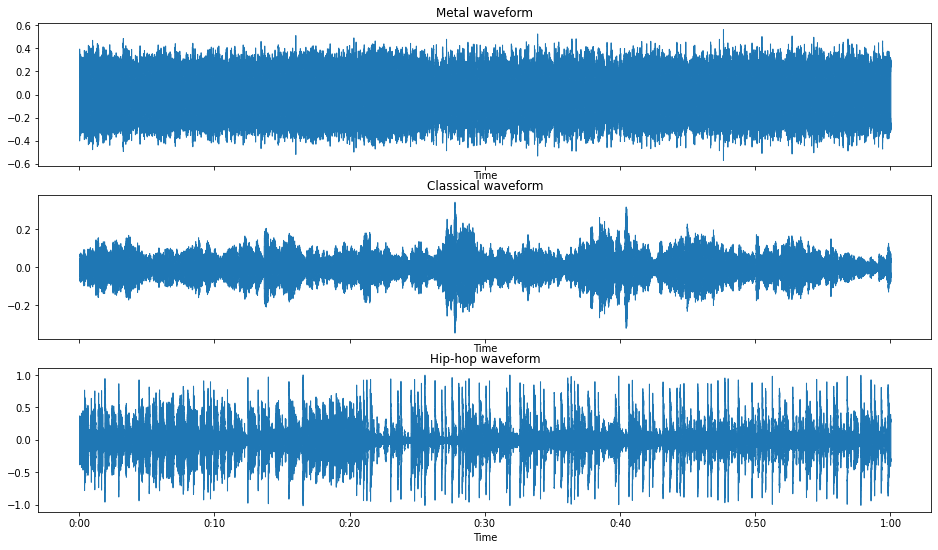

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.waveshow(metal_series, x_axis='time', ax=ax[0]) # Visualize a waveform in the time domain
ax[0].set(title='Metal waveform')

# Second subplot: classical
img2 = librosa.display.waveshow(classical_series, x_axis='time', ax=ax[1])
ax[1].set(title='Classical waveform')

# Third subplot: hip-hop
img3 = librosa.display.waveshow(hiphop_series, x_axis='time', ax=ax[2])
ax[2].set(title='Hip-hop waveform')

### Spectral Features ###

#### Mel Spectrogram ####

**Mel spectrograms** are a commonly used method for featurizing audio due to their representation, which is close to the human perception of the audio itself. A *mel* is a number that corresponds to a pitch. The term comes from the word ‘melodic’ and the mel scale is intended to regularize the intervals between notes.

To convert raw audio to a mel spectrogram we used *Librosa*'s:
* *melspectrogram()*, which uses by default a Fast Fourier Transform (FTT) window (n_fft) of 2048 and 512 samples between successive frames (hop_length). Other parameters in input are:
    * *y*: the audio time series extracted previously.
    * *sr*: an integer that corresponds to the desired sampling rate.
    * *n_mels*: the number of Mel bands (or bins) to generate.
    * *fmax*: the highest frequency (in Hz) to consider.
* *power_to_db()*, which returns the log-scaled spectrogram, from the spectrogram computed before.

The parameters for *melspectrogram()* were chosen based on the most clear view of differences between genres.

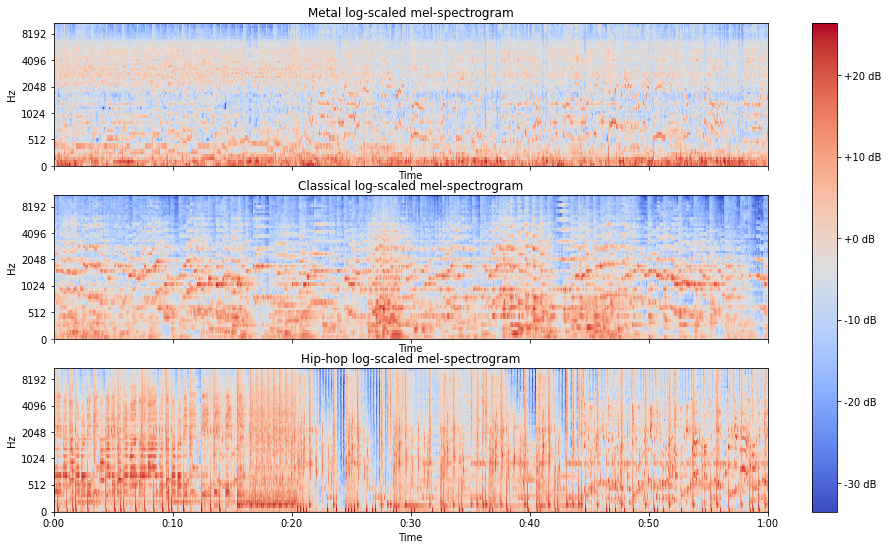

In [ ]:
mel_1 = librosa.feature.melspectrogram(y=metal_series, sr=sr, n_mels=64, fmax=8000)
log_mel_1 = librosa.power_to_db(mel_1)

mel_2 = librosa.feature.melspectrogram(y=classical_series, sr=sr, n_mels=64, fmax=8000)
log_mel_2 = librosa.power_to_db(mel_2)

mel_3 = librosa.feature.melspectrogram(y=hiphop_series, sr=sr, n_mels=64, fmax=8000)
log_mel_3 = librosa.power_to_db(mel_3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.specshow(log_mel_1, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Metal log-scaled mel-spectrogram')

# Second subplot: classical
img2 = librosa.display.specshow(log_mel_2, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Classical log-scaled mel-spectrogram')

# Third subplot: hip-hop
img3 = librosa.display.specshow(log_mel_3, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set(title='Hip-hop log-scaled mel-spectrogram')

fig.colorbar(img1, ax=[ax[0], ax[1], ax[2]], format="%+2.f dB", pad=0.05)

#### Chromagram ####

A **chromagram** represents chroma-based features, used to analyze music whose pitches can be meaningfully categorized. These features capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Similar musical pitches are part of the same **pitch class**. Based on this observation, a pitch can be separated into two components: 
1. **tone height**
2. **chroma**

Pitches that belong to the same pitch class share the same value for the chroma attribute. 

*Librosa* provides functions to compute a chromagram (*chroma_stft()*), from a waveform or power spectrogram, which aggregates information across all frequencies corresponding to a given pitch class.

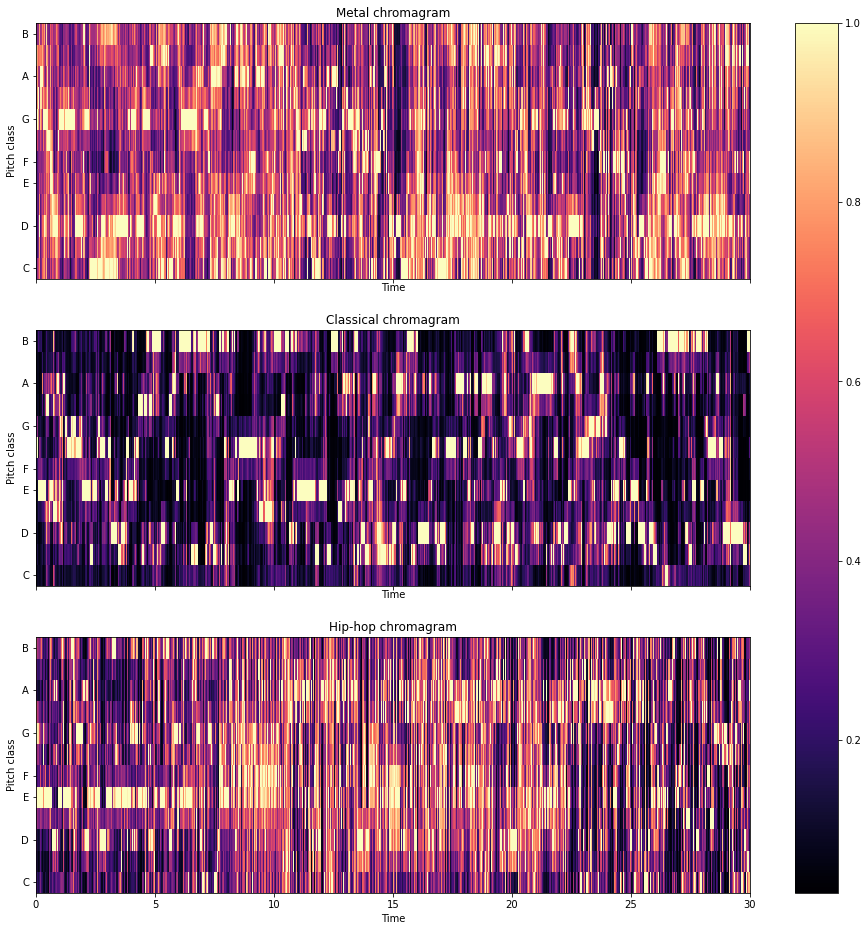

In [ ]:
chroma_1 = librosa.feature.chroma_stft(y=metal_series, sr=sr) # Compute the chromagram
chroma_2 = librosa.feature.chroma_stft(y=classical_series, sr=sr)
chroma_3 = librosa.feature.chroma_stft(y=hiphop_series, sr=sr)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharex=True)

img1 = librosa.display.specshow(chroma_1, sr=sr, x_axis='time', y_axis='chroma', ax=ax[0])
ax[0].set(title='Metal chromagram')

img2 = librosa.display.specshow(chroma_2, sr=sr, x_axis='time', y_axis='chroma', ax=ax[1])
ax[1].set(title='Classical chromagram')

img3 = librosa.display.specshow(chroma_3, sr=sr, x_axis='time', y_axis='chroma', ax=ax[2])
ax[2].set(title='Hip-hop chromagram')

plt.colorbar(img1, ax=[ax[0], ax[1], ax[2]], pad=0.05)

#### Zero Crossing Rate ####

One of the main characteristics used to classify the genre of a song, other than the set of instruments, is its percussive sound, or *drumkits* [4]. The **zero-crossing rate (ZCR)** is a key feature to classify percussive sounds.

Zero crossing is said to occur if successive samples have different algebraic signs, meaning that the waveform of a signal changes its sign by intersecting the zero line, where the signal is silent. The rate at which zero-crossings occur is a simple measure of the frequency content of a signal.

ZCR (*Z(i)*) is thus defined as the number of time-domain zero-crossings within a defined region of signal, divided by the number of samples of that region. 
$$Z(i)=\frac{\sum \limits _{i=1} ^{N} |sgn[x_{i}(n)] - sgn[x_{i}(n-1)]|}{2W_{L}}$$

A large number of zero crossings implies that there is no dominant low-frequency oscillation.

Although the songs used are quite general examples for their respective genres, it must be noted that ZCR may drastically change between songs of the same genre. This means that, beside a quick overview on the matter, the results should not be taken generally.

* *zero_crossing_rate()*, in addition to the time series, takes the length of the frame over which to compute zero crossing rates (frame_length) and the number of samples to advance for each frame (hop_length).
* *frames_to_time()* is used to reconvert frame counts to time, expressed in seconds.

Text(0.5, 1.0, 'Normalized zero-crossing rates for different music genres')

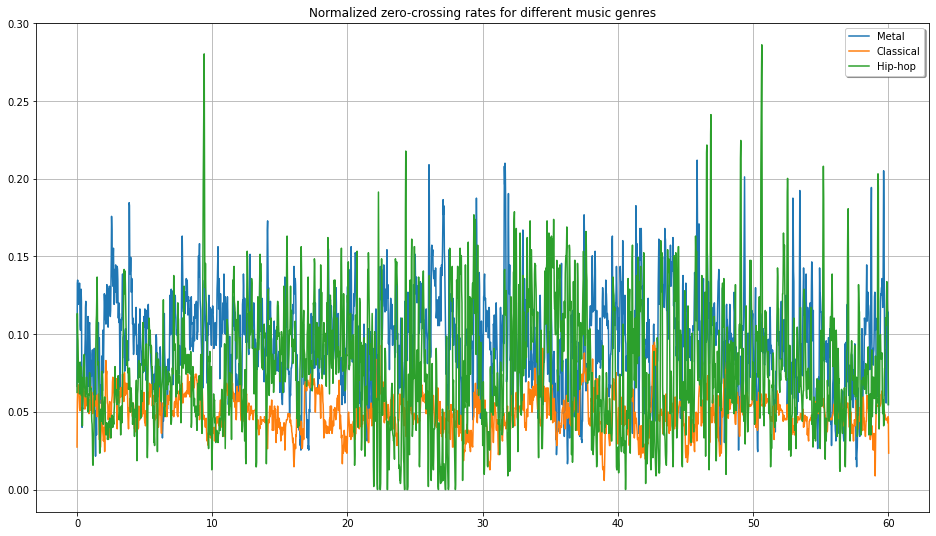

In [ ]:
zcr_metal = librosa.feature.zero_crossing_rate(metal_series, frame_length=1024, hop_length=512)[0]
frames_m = range(len(zcr_metal))
t_m = librosa.frames_to_time(frames_m, hop_length=512)

zcr_classical = librosa.feature.zero_crossing_rate(classical_series, frame_length=1024, hop_length=512)[0]
frames_c = range(len(zcr_classical))
t_c = librosa.frames_to_time(frames_c, hop_length=512)

zcr_hiphop = librosa.feature.zero_crossing_rate(hiphop_series, frame_length=1024, hop_length=512)[0]
frames_h = range(len(zcr_hiphop))
t_h = librosa.frames_to_time(frames_h, hop_length=512)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(t_m, zcr_metal, label='Metal')
ax.plot(t_c, zcr_classical, label='Classical')
ax.plot(t_h, zcr_hiphop, label='Hip-hop')

ax.legend(loc='best', shadow=True)

plt.grid()
plt.title("Normalized zero-crossing rates for different music genres")

## Features ##

### Numerical Features ###

The first step in a classification task is the creation of the dataset to use to train the classifier. In the case of music genre classification, this includes identifying the linguistic content and discarding noise from the audio files. 

Among the fundamental features used to categorize music genres are:

- **Chroma Frequencies**, used to analyze the *pitch* of the signal;
- **Zero Crossing Rate**, which describes percussive sounds;
- **Spectral Centroid**, which indicates where the "centre of mass" for a sound is located in terms of the weighted mean of the frequencies present in the sound;
- **Spectral Rolloff**, the frequency below which a specified percentage of the total spectral energy lies;
- **Mel-frequency cepstral coefficients (MFCCs)**, a small set of features which describe the overall shape of a spectral envelope.

These features are included in the CSV files that came along with the dataset. The list of features provided by GTZAN also includes:

- **RMS amplitude**, which describes the average signal amplitude;
- **Spectral Bandwidth**, the sum of maximum deviation of the signal on both sides of the centroid;
- **Harmony**
- **Tempo**

In addition, all these characteristics are computed in terms of mean and variance of the measure.

*Librosa* allows the generation of all these features. In the following code we provided an example for how to recover the values using this library. Finally the values generated are written in a CSV file to get the final dataset that can be used to train a MLP.

In [ ]:
def chroma_extractor(ts):
    chroma = librosa.feature.chroma_stft(y=ts, sr=sr)[0]
    return chroma

def zcr_extractor(ts):
    zcr = librosa.feature.zero_crossing_rate(ts, frame_length=1024)[0]
    return zcr

def spectral_centroid_extractor(ts):
    sc = librosa.feature.spectral_centroid(y=ts, sr=sr)[0]
    return sc

def spectral_rolloff_extractor(ts):
    sroll = librosa.feature.spectral_rolloff(y=ts, sr=sr)[0]
    return sroll

def mfccs_extractor(ts):
    mfccs = librosa.feature.mfcc(y=ts, sr=sr)
    return mfccs

In [ ]:
def features_extractor(row):
    ts, _ = librosa.load(row, sr=sr)
    
    row = f'{np.mean(chroma_extractor(ts))} {np.mean(zcr_extractor(ts))} {np.mean(spectral_centroid_extractor(ts))} '
    row += f'{np.mean(spectral_rolloff_extractor(ts))}'
    
    for mfcc in mfccs_extractor(ts):
        row += f' {np.mean(mfcc)}'
        
    return row

In [ ]:
def retrieve_features(directory, num_classes):
    header = 'filename chroma_stft zero_crossing_rate spectral_centroid spectral_rolloff'

    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    file = open('custom_features.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
        
    i = 0
    for folder in os.listdir(directory): # genre folders
        i += 1
        if i == num_classes+1:
            break   
            
        for file in os.listdir(directory + folder): # audio files in each genre folder
            
            path = directory + folder + "/" + file
            
            row = f'{file} '
            row += features_extractor(path)
            row += f' {folder}'
            
            file = open('custom_features.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(row.split())
                
    file.close()

In [ ]:
retrieve_features(directory=path_to_audios, num_classes=10)

In [ ]:
df = pd.read_csv(path_to_dataset_dir+"/features_3_sec.csv") # read features
df = df.drop(labels='filename', axis=1) # drop the first column

df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### Images ###

Despite everything that was said before, using CNNs we will actively use the visual representation of a single feature: input images have to represent the same characteristic to help the model learn which visualizations belong to each class, meaning each genre. 

Since Mel Spectrograms work well for most audio deep learning applications, input images are the **Mel Spectrograms** of each audio sample. Modifing these images in a **pre-processing** phase and storing them afterwards, before the actual training process, makes the latter faster than having to compute them on the run.

In [ ]:
# Load images
def get_images(directory, num_classes):

    i = 0
    input_arr = []
    for folder in os.listdir(directory): # genre folders
        i += 1
        if i == num_classes+1:
            break   

        for file in os.listdir(directory + folder): # images in each genre folder

            path = directory + folder + "/" + file
            
            image = k.preprocessing.image.load_img(path)
            input_arr.append(k.preprocessing.image.img_to_array(image))

    input_arr = np.array([input_arr])  # Convert single image to a batch.
    return input_arr

In [ ]:
input_array = get_images(directory=path_to_images_original, num_classes=10)

### Data augmentation ###

The spectrograms provided by GTZAN, computed from the audio samples, may be good enough for our task. However, 1000 input images, to split in training and test set, may be too few to get valid evaluation metrics.

To augment data artificially, there are several techniques that can be performed:
* on the **raw audio**, sampling a contigous 3-second window from each clip, augmenting the available data to 10.000 files *before producing the spectrogram*;
* on the generated **spectrogram**, which usually produces better results.

For the latter, the usual images manipulations (horizontal flip or rotation) won’t apply, since they would substantially alter the spectrogram and the sound that it represents. Instead, we used a method known as *SpecAugment*, where we block out sections of the spectrogram [5].
This method is simple and computationally cheap to apply, as it directly acts on the log mel spectrogram and does not require any additional data. 

It consists of three kinds of deformations of the spectrogram:

- **Time warping**, which is a deformation of the time-series in the time direction.
- **Frequency mask**, which randomly mask out a range of consecutive frequencies by adding *horizontal bars* on the spectrogram.
- **Time mask**, which randomly blocks out ranges of time from the spectrogram by using *vertical bars*.

In [ ]:
def time_warp(mel, warp=80):
    
    # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
    mel = np.reshape(mel, (-1, mel.shape[0], mel.shape[1], 1))

    v, tau = mel.shape[1], mel.shape[2]

    horiz_line_thru_ctr = mel[0][v//2]

    random_pt = horiz_line_thru_ctr[random.randrange(warp, tau - warp)] # random point along the horizontal/time axis
    w = np.random.uniform((-warp), warp) # distance

    # Source Points
    src_points = [[[v//2, random_pt[0]]]]

    # Destination Points
    dest_points = [[[v//2, random_pt[0] + w]]]

    mel, _ = tfa.image.sparse_image_warp(mel, src_points, dest_points, num_boundary_points=2)

    return mel
    

def freq_mask(mel, v, mask=27, num_masks=2):

    # apply m_F frequency masks to the mel spectrogram
    for i in range(num_masks):
        f = int(np.random.uniform(0, mask)) # [0, F)
        f0 = random.randint(0, v - f) # [0, v - f)
        mel[f0:f0 + f, :] = 0

    return mel

    
def time_mask(mel, tau, mask=100, num_masks=2):

    # apply m_T time masks to the mel spectrogram
    for i in range(num_masks):
        t = int(np.random.uniform(0, mask)) # [0, T)
        t0 = random.randint(0, tau - t) # [0, tau - t)
        mel[:, t0:t0 + t] = 0

    return mel
    

In [ ]:
def save_spectrogram(mel, path, warp):
    
    if warp:
        log_mel = librosa.amplitude_to_db(mel[0, :, :, 0].numpy(), ref=np.max)
    else:
        log_mel = librosa.amplitude_to_db(mel, ref=np.max)
    
    plt.figure()
    plt.axis('off')

    librosa.display.specshow(log_mel)
    
    plt.savefig(path)
    plt.close()

In [ ]:
def augmentation(src_dir, dest_dir, num_classes):
    
    if not os.path.exists(dest_dir):
        try: 
            os.mkdir(dest_dir) 
        except OSError as error: 
            print(error)  
    
    i = 0
    for folder in os.listdir(src_dir): # genre folders
        i += 1
        if i == num_classes+1:
            break   
            
        for file in os.listdir(src_dir + folder): # songs in each genre folder
            
            if not os.path.exists(dest_dir + folder):
                try: 
                    os.mkdir(dest_dir + folder) 
                except OSError as error: 
                    print(error)  
           
            path = src_dir + folder + "/" + file
            filename = file.replace('.wav', '')
            filename = filename.replace('.', '')

            rec, sr = librosa.load(path, sr=44100)

            # Original MS
            save_path = dest_dir + folder + "/" + filename + ".png"  
            mel = librosa.feature.melspectrogram(y=rec, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
            save_spectrogram(mel, save_path, False)

            v = mel.shape[0]
            tau = mel.shape[1]

            # Time Warp
            mel_warp = time_warp(mel) # Applies Time Warping to the mel spectrogram
            save_path = dest_dir + folder + "/" + filename + "_w.png"
            save_spectrogram(mel_warp, save_path, True)

            # Frequency mask
            mel_freq = freq_mask(mel, v) # Applies Frequency Masking to the mel spectrogram
            save_path = dest_dir + folder + "/" + filename + "_f.png"
            save_spectrogram(mel_freq, save_path, False)

            # Time mask
            mel = librosa.feature.melspectrogram(y=rec, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
            mel_time = time_mask(mel, tau) # Applies Time Masking to the mel spectrogram
            save_path = dest_dir + folder + "/" + filename + "_t.png"
            save_spectrogram(mel_time, save_path, False)

In [ ]:
augmentation(src_dir=path_to_audios, dest_dir=path_to_images_augmented, num_classes=10)

## Model building ##

### Convolutional Neural Network - Architectures ###

The CNN model works in two steps:

- **Feature Extraction**, where various filters and layers are applied to the images to extract its information and features.

- **Classification**, when instances are classified based on the target variable of the problem.

*TensorFlow* [6] and *Keras* [7] provide means to implement the main characteristic of a CNN: a convolutional window that scans over the input data and output the result of a given operation on the elements within the window. The result gets fed into a max pool layer that selects the maximum element from another window.

A common architectural pattern for CNNs is structued in:

- A sequence of pairs (CONV layer + RELU layer) followed by a sequence of POOL layers. This is repeated until a sufficiently small output is reached.

- A sequence of pairs (FC layer + RELU layer) followed by an output FC layer that gives the scores related to each class.

<figure>
<img src='https://drive.google.com/uc?id=1PKHhDc1Xxq9STtFm9Ljr57X-J9l0xMIJ'>
<figcaption><b>Fig.1 - R. Basili, Web Mining and Retrieval, A.A. 2020/21</b></figcaption>
</figure>

A **2D convolutional layer** (**CONV**) can process 2D input images. The arguments passed to the function that implements the layer (*keras.layers.Conv2D()*) are:
- The number of **output channels**; 
- The **kernel size**, meaning the dimensions of the moving window; 
- The **strides** in the x and y directions ((1, 1) by default);
- The **activation** function;
- The **size** of the **input** to the layer.

A **2D max pooling layer** (**POOL**) applies a dimensional reduction of the output from the previous layer. The arguments passed to the function that implements the layer (*keras.layers.MaxPooling2D()*) are:
- the **size** of the **pooling** in the x and y directions
- the **strides** (same size as the pooling by default).

The **fully connected layers** (**FC**) are implemented using the *keras.layers.Dense()* layer in Keras, which specifies the number of nodes and their activation function.  

The output layer generally uses a **softmax** classification on the classes to output the results (we are in case of multi-classification).

According to a *transfer learning* approach, we didn't build a CNN from scratch, but we studied popular models with high perfomances to use with our dataset.

#### Huang ####

In a paper of 2018, Derek Huang (et al.) analyzed the performances of different types of classifiers (KNN, SVM, FFNN and CNN) on the same dataset that we use here, augmented during sampling: they sampled a contigous 2-seconds window at four random locations, retrieving 8000 clips of 2 seconds each from the original files.

As the paper reports, the **CNN** is the one that performed better among the four and it is the one that we analyze here. [1].

The architecture consists of:
- 3 **convolutional** (**CONV**) layers, each with its own max pool and regularization. The convolution windows scan over the input data and output the sum of the elements within the window. This then gets fed into a max pool layer that selects the maximum element from another window.
- 3 **fully connected** (**FC**) layers with **ReLU** activation, **softmax** output and **cross entropy** loss.

<figure>
<img src='https://drive.google.com/uc?id=1NaPDCsEz-CKw1sRFuBnuPBRpYE0q_qt0'>
<figcaption><b>Fig.2 - D. Huang, Music Genre Classification - CNN Architecture. 2018.</b></figcaption>
</figure>

In [ ]:
# Huang Architecture
def huang(input_shape=(64,173,1)):
    
    cnn = k.models.Sequential([
        
        # 2D convolution layer (e.g. spatial convolution over images)
        k.layers.Conv2D(64, kernel_size=(4, 4), activation='relu', input_shape=input_shape), 
        
        # applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
        k.layers.BatchNormalization(), 
        
        # Max pooling operation for 2D spatial data
        k.layers.MaxPooling2D(pool_size=(2, 4)), 
        
        k.layers.Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        k.layers.MaxPooling2D(pool_size=(2, 2)), 
        
        # Applies Dropout to the input
        k.layers.Dropout(0.2),
        
        k.layers.Conv2D(64, (2, 2), activation='relu'),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(2, 2)), 
        k.layers.Dropout(0.2),
        
        # Flattens the input
        k.layers.Flatten(),
        
        # Fully connected layer
        k.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        
        k.layers.Dropout(0.5),
        k.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        k.layers.Dense(10, activation='softmax')
    ])
    
    return cnn

#### AlexNet ####

In 2010, from the efforts of Alex Krizhevky and his team, AlexNet was created to provide a new state of the art image classification during the ImageNet contest. Our analysis comes from the paper of 2012: "ImageNet Classification with Deep Convolutional Neural Networks" [8].

As described in the paper, the network contains eight layers, where the first five are **convolutional** and the remaining three are **fully connected**. The output of the last fully connected layer is fed to a **softmax** which produces a distribution over the class labels. 

- The **first** convolutional layer filters a 224x224x3 input image with 96 kernels of size 11x11x3 with a stride of 4 pixels. Pooling and normalization are applied.

- The **second** convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with 256 kernels of size 5x5x48.

- The **third**, **fourth**, and **fifth** convolutional layers are connected to one another without **any intervening pooling** or **normalization** layers. 
    - The third convolutional layer has 384 kernels of size 3x3x256 connected to the (normalized, pooled) outputs of the second convolutional layer. 
    - The fourth convolutional layer has 384 kernels of size 3x3x192.
    - The fifth convolutional layer has 256 kernels of size 3x3x192. 

<figure>
<img src='https://drive.google.com/uc?id=1zwBejC6lnZDrFnI2lTdyKL3KCMlrBHcm'>
<figcaption><b>Fig.3 - A. Krizhevsky, ImageNet Classification with Deeper Convolutional Neural Network. - CNN Architecture.</b></figcaption>
</figure>

The **ReLU** non-linearity is applied to the output of every convolutional and fully-connected layer.

The **Dropout**, which was a fairly new technique at the time, was used to reduce overfitting. It was used with probability 0.5 in the first two fully connected layers. This means that half of the perceptrons are deactivated.
    
As optimizer, AlexNet uses **Stochastic Gradient Descent** (**SGD**) with a batch size of 128 and momentum of 0.9. This approach to training is not followed in this analysis, for we used **Adam** as a 'de-facto' optimizer.

They used weight decay of 0.0005. Weight initialization is done using **zero-mean Gaussian** distribution with a standard deviation of 0.01. 

They also **initialized** the neuron **biases** in the second, fourth, and fifth convolutional layers, as well as in the fully connected hidden layers, with the constant **1**. This initialization accelerates the early stages of learning by providing the ReLUs with positive inputs. 

In [ ]:
# AlexNet Architecture
def alexnet(input_shape=(224,224,3)):
    
    cnn = k.models.Sequential([
        k.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                        input_shape=input_shape),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Conv2D(256, (5, 5), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                        bias_initializer='ones'),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Conv2D(384, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01)),
        k.layers.Conv2D(384, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                        bias_initializer='ones'),
        k.layers.Conv2D(256, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                        bias_initializer='ones'),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Flatten(),
        k.layers.Dense(4096, 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                       bias_initializer='ones'),
        k.layers.Dropout(0.5),
        k.layers.Dense(4096, 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                       bias_initializer='ones'),
        k.layers.Dropout(0.5),
        k.layers.Dense(10, activation='softmax', 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
    ])
    
    return cnn

#### GoogLeNet ####

**GoogLeNet** was proposed by Szegedy et al. in 2014, winning the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC-2014) [9]. 

To build models that results in higher accuracy, a common approach is to uniformly increased network size, as in depth and width. However, this means:
- a larger number of parameters, which makes the enlarged network more prone to overfitting,
- a dramatic increase in the use of computational resources.

GoogleNet was designed in a special architecture that allows for increasing the depth and width of the network but **keeping the computing resource**. 

To solve both this issues networks should be moving from fully connected to **sparsely connected architectures**, even inside the convolutions. At the time this paper was written, computing infrastructures were very inefficient w.r.t. numerical calculation on non-uniform sparse data structures, which led to build an architecture that makes use of the extra sparsity, even at filter level, utilizing computations on dense matrices. 

This is where **Inception** comes into play.

The main idea of the Inception architecture is based on finding out how an optimal local sparse structure in a convolutional vision network can be approximated and covered by readily available dense components.

The network is 22 layers deep when counting only layers with parameters (or 27 layers if we also count pooling). It uses:

- The Inception networks. Each Inception block consists of four parallel paths, each with appropriate padding so that the input and output have the same size, at which convolution layers with different kernel sizes are applied. The concatenation of these four paths allows scanning the input in different resolutions and the model complexity is minimized thanks to the application of a 1×1 convolutional layer in each path:
    - The first path uses a convolutional layer with a window size of 1×1.
    - The second and third paths use a convolutional layer of size 1×1 before applying, respectively, a 3×3 and a 5×5 convolution.
    - The fourth path uses a max-pooling layer to reduce the resolution of the input, and it is followed by a 1×1 convolutional layer.

- Two extra networks. These encourage discrimination in the lower stages in the classifier, increasing the gradient signal that gets backpropagation and providing additional regularization:
    - An average pooling layer with pooling size 5×5 and stride 3.
    - A 1×1 convolutional layer with 128 filters for dimensional reduction and a rectified linear activation.
    - A fully connected layer with 1024 units and a rectified linear activation.
    - A dropout with a ratio of 70% of outputs.
    - An output layer that used a softmax activation function to classify the object into one of the classes.

Every max-pooling layer, especially outside the Inception blocks, helps reducing the size of the input data, thus reduce the model complexity as well as the computational cost. Moreover, average pooling layers are used to improve the model performance and reduce overfitting.

<figure>
<img src='cnn_google_1.png'>
<figcaption align = "center"><b>Fig.4 - C. Szegedy - GoogleNet Architecture. 2015</b></figcaption>
</figure>

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    
    # 1st path:
    path1 = k.layers.Conv2D(f1, (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = k.layers.Conv2D(f2_conv1, (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = k.layers.Conv2D(f2_conv3, (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = k.layers.Conv2D(f3_conv1, (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = k.layers.Conv2D(f3_conv5, (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = k.layers.MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = k.layers.Conv2D(f4, (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = k.layers.Concatenate(axis = -1)([path1, path2, path3, path4])

    return output_layer

In [ ]:
def googlenet(input_shape=(224,224,3)):

    # input layer 
    input_layer = k.layers.Input(shape=input_shape)

    X = k.layers.Conv2D(64, (7,7), strides=2, padding='valid', activation='relu')(input_layer)
    X = k.layers.MaxPooling2D(3, strides=2)(X)
    #LRN
    X = k.layers.Conv2D(64, (1,1), padding = 'same', activation = 'relu')(X)
    X = k.layers.Conv2D(192, (3,3), padding = 'same', activation = 'relu')(X)
    #LRN
    X = k.layers.MaxPooling2D((3,3), strides=2)(X)

    # Inception blocks
    X = Inception_block(X, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)

    X = k.layers.MaxPooling2D((3,3), strides=2)(X)

    X = Inception_block(X, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)

    # Extra network 1
    X1 = k.layers.AveragePooling2D((5,5), strides=3)(X)
    X1 = k.layers.Conv2D(128, (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = k.layers.Flatten()(X1)
    X1 = k.layers.Dense(1024, activation = 'relu')(X1)
    X1 = k.layers.Dropout(0.7)(X1)
    X1 = k.layers.Dense(10, activation = 'softmax')(X1)

    # Inception blocks
    X = Inception_block(X, f1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4=64)
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4=64)
    X = Inception_block(X, f1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4=64)

    # Extra network 2:
    X2 = k.layers.AveragePooling2D((5,5), strides=3)(X)
    X2 = k.layers.Conv2D(128, (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = k.layers.Flatten()(X2)
    X2 = k.layers.Dense(1024, activation = 'relu')(X2)
    X2 = k.layers.Dropout(0.7)(X2)
    X2 = k.layers.Dense(10, activation = 'softmax')(X2)

    X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = k.layers.MaxPooling2D(3, strides=2)(X)

    X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)
    X = Inception_block(X, f1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4=128)

    # Global Average pooling layer 
    X = k.layers.GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = k.layers.Dropout(0.4)(X)

    # output layer 
    X = k.layers.Dense(10, activation = 'softmax')(X)

    # model
    cnn = k.models.Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    
    return cnn

#### MLP simple architecture ####

To use our numerical features and analyze the performances of a model that uses them, instead of plain images, we used a simple, but 'deep', Multilayer Perceptron.

This uses 3 hidden layers, ReLu activation and goes from 512 channels in the input layer, to 64 channels in the hidden layer right before classification. 

To avoid overfitting, the dropout is applied with a 20% probability to every step of the computation.

In [ ]:
def mlp():
    mlp = k.models.Sequential([k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(256, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(128, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(64, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(10, activation='softmax')])

    return mlp

### Training ###

The same batch size and number of epochs were used for every model. 

In particular, the number of epochs was tuned while performing a training on 1000 epochs with a patience of 100 on the 'early stopping' mechanism. Considering that all three models stopped below the 300 epochs (251 was the maximum with AlexNet), we decided to set 300 training epochs with a patience of 20. The performances with these new parameters were the same as with the older parameters.

To set the 'early stopping', callbacks are used to track the training process. Here, we used the **EarlyStopping** class in *Keras* to stop the training when a the loss on the validation set doesn't improve after 20 epochs. This helps in avoiding useless computational effort and waste of time.

In [ ]:
def training(model, training, labels, validation, epochs, optimizer, loss, metrics):
    
    # Stop training when a loss on test has stopped improving
    # Used only for MLP
    # early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1) 
    
    model.compile(optimizer, loss, metrics)
    
    return model.fit(training, labels, batch_size=128, epochs=epochs, callbacks=[early_stopping], validation_data=validation)

#### Categorical classes ####

The classes of this task are categorical, so there's a need to convert them into model-understandable numerical data. 

When dealing with the CSV, we used *SciKit Learn*'s **LabelEncoder** class to encode target labels with value between 0 and num_classes-1 (like in 1-to-K Encoding). Moreover, **StandardScaler** helps in the normalization of the features, necessary to get higher performances for most classifiers.

In [ ]:
class_list = df.iloc[:,-1] # Selection by position

encoder = LabelEncoder()
y = encoder.fit_transform(class_list) # Fit label encoder and return encoded labels

fit = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
X = fit.fit_transform(np.array(df.iloc[:,:-1], dtype=float)) 

# show which features are being used
# print(df.iloc[:,:-1]) 

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

#### Validation techniques ####

##### MLP #####

As a validation approach, k-fold cross-validation is often used for simple models with few parameters, simple hyperparameters and models that are easy to optimize (e.g. linear regression, logistic regression, small neural networks and support vector machines).

This can be applied, for example, to our MLP, but, as it is not the main focus of this analysis, a simpler 80/20/20 splitting approach was used.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

##### CNN #####

For a CNN with many parameters, the experiments usually focus on learning rate, batch size, dropout and batch normalization, so it is generally used a split by percentage od training, test and, eventually, validation set.

We used *Keras* to generate a tensor dataset from the sound images previously augmented. The color set specified is *greyscale* which means that only 1 channel in the tensor is used for the colors when encoding the image.

In [ ]:
def get_dataset(directory, batch, color_mode):
    dataset = k.utils.image_dataset_from_directory(directory=directory, batch_size=batch, color_mode=color_mode)
    return dataset

In [ ]:
dataset = get_dataset("Dataset/images_augmented", None, "grayscale")

Found 3996 files belonging to 10 classes.


In [ ]:
 def is_test(x, y):
    return x % 5 == 0 # 80/20 split: 1 instance out of 5 is added to the test set 

def is_train(x, y):
    return not is_test(x, y)

def get_dataset_partitions(dataset, dataset_size, num_classes):

    recover = lambda x,y: y
    dataset = dataset.shuffle(dataset_size)

    temp_ds = dataset.enumerate().filter(is_train).map(recover)
    val_ds = dataset.enumerate().filter(is_test).map(recover)
    
    train_ds = temp_ds.enumerate().filter(is_train).map(recover)
    test_ds = temp_ds.enumerate().filter(is_test).map(recover)

    X_train, Y_train = zip(*train_ds)
    X_val, Y_val = zip(*val_ds)
    X_test, Y_test = zip(*test_ds)

    # One-Hot encoding for classes: convert classes into categorical vectors
    Y_train = np.array(k.utils.to_categorical(Y_train, num_classes))
    Y_val = np.array(k.utils.to_categorical(Y_val, num_classes))
    Y_test = np.array(k.utils.to_categorical(Y_test, num_classes))
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = get_dataset_partitions(dataset, dataset_size=3996, num_classes=10)

#### Loss and optimization ####

*Keras* supplies many loss functions and optimizers. 

In this case, we will use the standard cross entropy for categorical classification (categorical_crossentropy) and the Adam optimizer that mitigates the sparse gradient problem of two dimensional time-series, maintaining a per-parameter learning rate, and the noise problem of audio data, basing updates on a weighted average of recent updates.

#### Other training hyperparameters ####

In [ ]:
def reshape_input(X_train, X_val, X_test, x, y, z):
    
    X_train = tf.image.resize(X_train, [x, y]).numpy()
    X_val = tf.image.resize(X_val, [x, y]).numpy()
    X_test = tf.image.resize(X_test, [x, y]).numpy()
    
    # Reshape for CNN architecture
    X_train = np.array([a.reshape((x, y, z)) for a in X_train])
    X_val = np.array([a.reshape((x, y, z)) for a in X_val])
    X_test = np.array([a.reshape((x, y, z)) for a in X_test])
    
    return X_train, X_val, X_test 

#### CNNs training ####

##### Huang #####

In [ ]:
input_shape = (64, 173, 1)

x_train, x_val, x_test = reshape_input(x_train, x_val, x_test, input_shape[0], input_shape[1], input_shape[2])

huang_net = huang(input_shape=input_shape)
print(huang_net.summary())

#Num of epoch is set to MLP baseline
trained_huang = training(huang_net, x_train, y_train, validation=(x_val, y_val), 
                         epochs=43, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 61, 170, 64)       1088      
                                                                 
 batch_normalization_8 (Batc  (None, 61, 170, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 38, 64)        61504     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 19, 64)       0         
 g2D)                                                            
                                                      

KeyboardInterrupt: 

##### AlexNet #####

In [ ]:
input_shape = (224, 224, 1)

x_train, x_val, x_test = reshape_input(x_train, x_val, x_test, input_shape[0], input_shape[1], input_shape[2])

alexnet = alexnet(input_shape=input_shape)
print(alexnet.summary())

trained_alex = training(alexnet, x_train, y_train, validation=(x_val, y_val),
                       epochs=43, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 384)        

KeyboardInterrupt: 

##### GoogLeNet #####

In [ ]:
input_shape = (224, 224, 1) #AlexNet, GoogLeNet

x_train, x_val, x_test = reshape_input(x_train, x_val, x_test, input_shape[0], input_shape[1], input_shape[2])

googlenet = googlenet(input_shape=input_shape)
print(googlenet.summary())

trained_google = training(googlenet, x_train, y_train, validation=(x_val, y_val),
                           epochs=43, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

#### MLP training ####

In [ ]:
mlp = mlp()
print(mlp.summary())

trained_mlp = training(mlp, x_train, y_train, validation=(x_val, y_val),
                       epochs=300, optimizer='adam', loss='sparse_categorical_crossentropy', 
                       metrics='accuracy')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               30208     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

### Saving models ###

In [ ]:
def save_checkpoints(model, filename):
    model.save_weights(filename)

In [ ]:
def save_performances_to_csv(model, filename):
    model_df = pd.DataFrame(model.history) 
    with open(filename, mode='w') as f:
        model_df.to_csv(f)

In [ ]:
#CNN - Huang
save_checkpoints(huang_net, 'checkpoints/Huang/huang_checkpoint')
save_performances_to_csv(trained_huang, 'Trained/huang.csv')

In [ ]:
#CNN - AlexNet
save_checkpoints(alexnet, 'checkpoints/Alex/alex_checkpoint')
save_performances_to_csv(trained_alex, 'Trained/alex.csv')

InvalidArgumentError: Failed to create a directory: ram:; Invalid argument

In [ ]:
#CNN - GoogLeNet
save_checkpoints(googlenet, 'checkpoints/Google/google_checkpoint')
save_performances_to_csv(trained_google, 'Trained/google.csv')

INFO:tensorflow:Restoring parameters from Trained/mlp.ckpt


In [ ]:
#MLP
save_checkpoints(mlp, 'checkpoints/MLP/mlp_checkpoint')
save_performances_to_csv(trained_mlp, 'Trained/mlp.csv')

## Model Evaluation ##

The metric evaluated to describe the performance of the model is accuracy.

### Test set evaluations ###

Listed below are the performances of every model w.r.t its own test set. These evaluations were made after the training saved in the respective CSV files.

Performance metrics are listed as 'loss' and 'accuracy' obtained, respectively.

**MLP**: [0.3889932632446289, 0.9109109044075012]

**Huang**: [1.0650087594985962, 0.8921874761581421]

**AlexNet**: [0.8513029217720032, 0.8265625238418579]

**GoogLeNet**: [1.1404943466186523, 0.45017385482788086]

### General evaluation ###

An evaluation can be made loading the saved models and recreating the set for the evaluation. This approach does not guarantee that images used for training will not be used for testing.

In [ ]:
def load_checkpoints(sequential, path, optimizer, loss, metrics):
    
    sequential.compile(optimizer, loss, metrics)
    sequential.load_weights(path)

    return sequential

In [ ]:
new_seq = huang(input_shape=(64,173,1))
new_model = load_checkpoints(new_seq, 'checkpoints/Huang/huang_checkpoint', 
                             optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
new_seq = alexnet(input_shape=(224,224,1))
new_model = load_checkpoints(new_seq, 'checkpoints/Alex/alex_checkpoint', 
                             optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
new_seq = googlenet(input_shape=(224,224,1))
new_model = load_checkpoints(new_seq, 'checkpoints/Google/google_checkpoint', 
                             optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
new_seq = mlp()
new_model = load_checkpoints(new_seq, 'checkpoints/MLP/mlp_checkpoint', 
                             optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
results = new_model.evaluate(x_test, y_test, batch_size=128)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

### Plots ###

In [ ]:
def plot_validate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

Validation Accuracy 0.9674457311630249


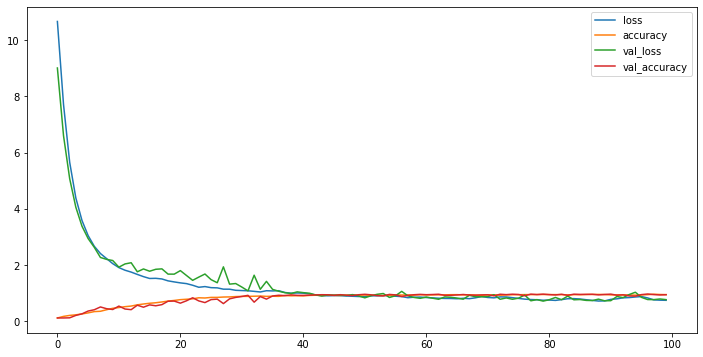

In [ ]:
plot_validate(trained_cnn)

Validation Accuracy 0.9114346504211426


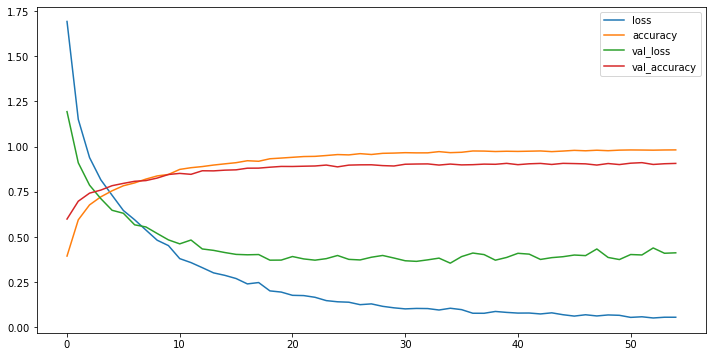

In [ ]:
plot_validate(trained_mlp)

## Conclusions ##

### Parameters ###

In [9] it is described how the Dense layers always take a majority of parameters, but the global average pooling layers helps to reduce significantly the parameter number, thus reducing the computational complexity of the model.

GoogLeNet is said to use 12x fewer parameters than AlexNet (2012 version), while being significantly more accurate.

| Network   | Total params | Trainable params | Non-trainable params |
|-----------|--------------|------------------|----------------------|
| Huang     |    303,210   |     302,954      |         256          |
| AlexNet   |  21,598,922  |   21,598,922     |          0           |
| GoogLeNet |   8,492,750  |    8,492,750     |          0           |
| MLP       |    203,338   |     203,338      |          0           |

### Accuracy ###

| Network   | Reported Accuracy*| Obtained Accuracy |
|-----------|-------------------|-------------------|
| Huang     |        82%        |        89%        |
| AlexNet   |       83.6%       |        83%        |
| GoogLeNet |       93.3%       |        45%        |
| MLP       |         /         |        91%        |

*As reported in the relative paper (sometimes as top-5 error)

## References ##

1. D. A. Huang, A. A. Serafini, E. J. Pugh. Music Genre Classification. 2018. Standford University.
2. GTZAN. https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download
3. Librosa. https://librosa.org/doc/latest/index.html
4. R. Basili, A. Serafini, A. Stellato. Classification of musical genre: a machine learning approach. University of Rome Tor Vergata.
5. D. S. Park et al. SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition. Google Brain research team. 2019.
6. Tensorflow. https://www.tensorflow.org/
7. Keras. https://keras.io/
8. A. Krizhevsky, I. Sutskever, G. E. Hinton. ImageNet Classification with Deeper Convolutional Neural Network.
9. C. Szegedy et al. Going deeper with convolutions. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015. 
10. https://towardsdatascience.com/alexnet-8b05c5eb88d4
11. https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c 